# Hybrid Knowledge Graph + vector database Retrieved Augmented Generation

The goal is to build a knowledge graph + vector database supported Retrieved Augmented Generation, where information from a PDF file processed, these information is stored in the databases. When a user query comes retrieve context information which helps the answer generation of the selected model.

### Overview:

1. Install required packages
2. Initialize the two databases
3. Split the text into sematically relevant chunks
4. Build the knowledge graph and vector database
  - Extract **subject** ---**predicate**---> **object** triplets from each chunks
  - Refining triplets, actualizing triplet information, merge information of same entities
6. Write retrieving process
7. Ask the model questions regarding the PDF, compare the results while using no context

### Architecture overview

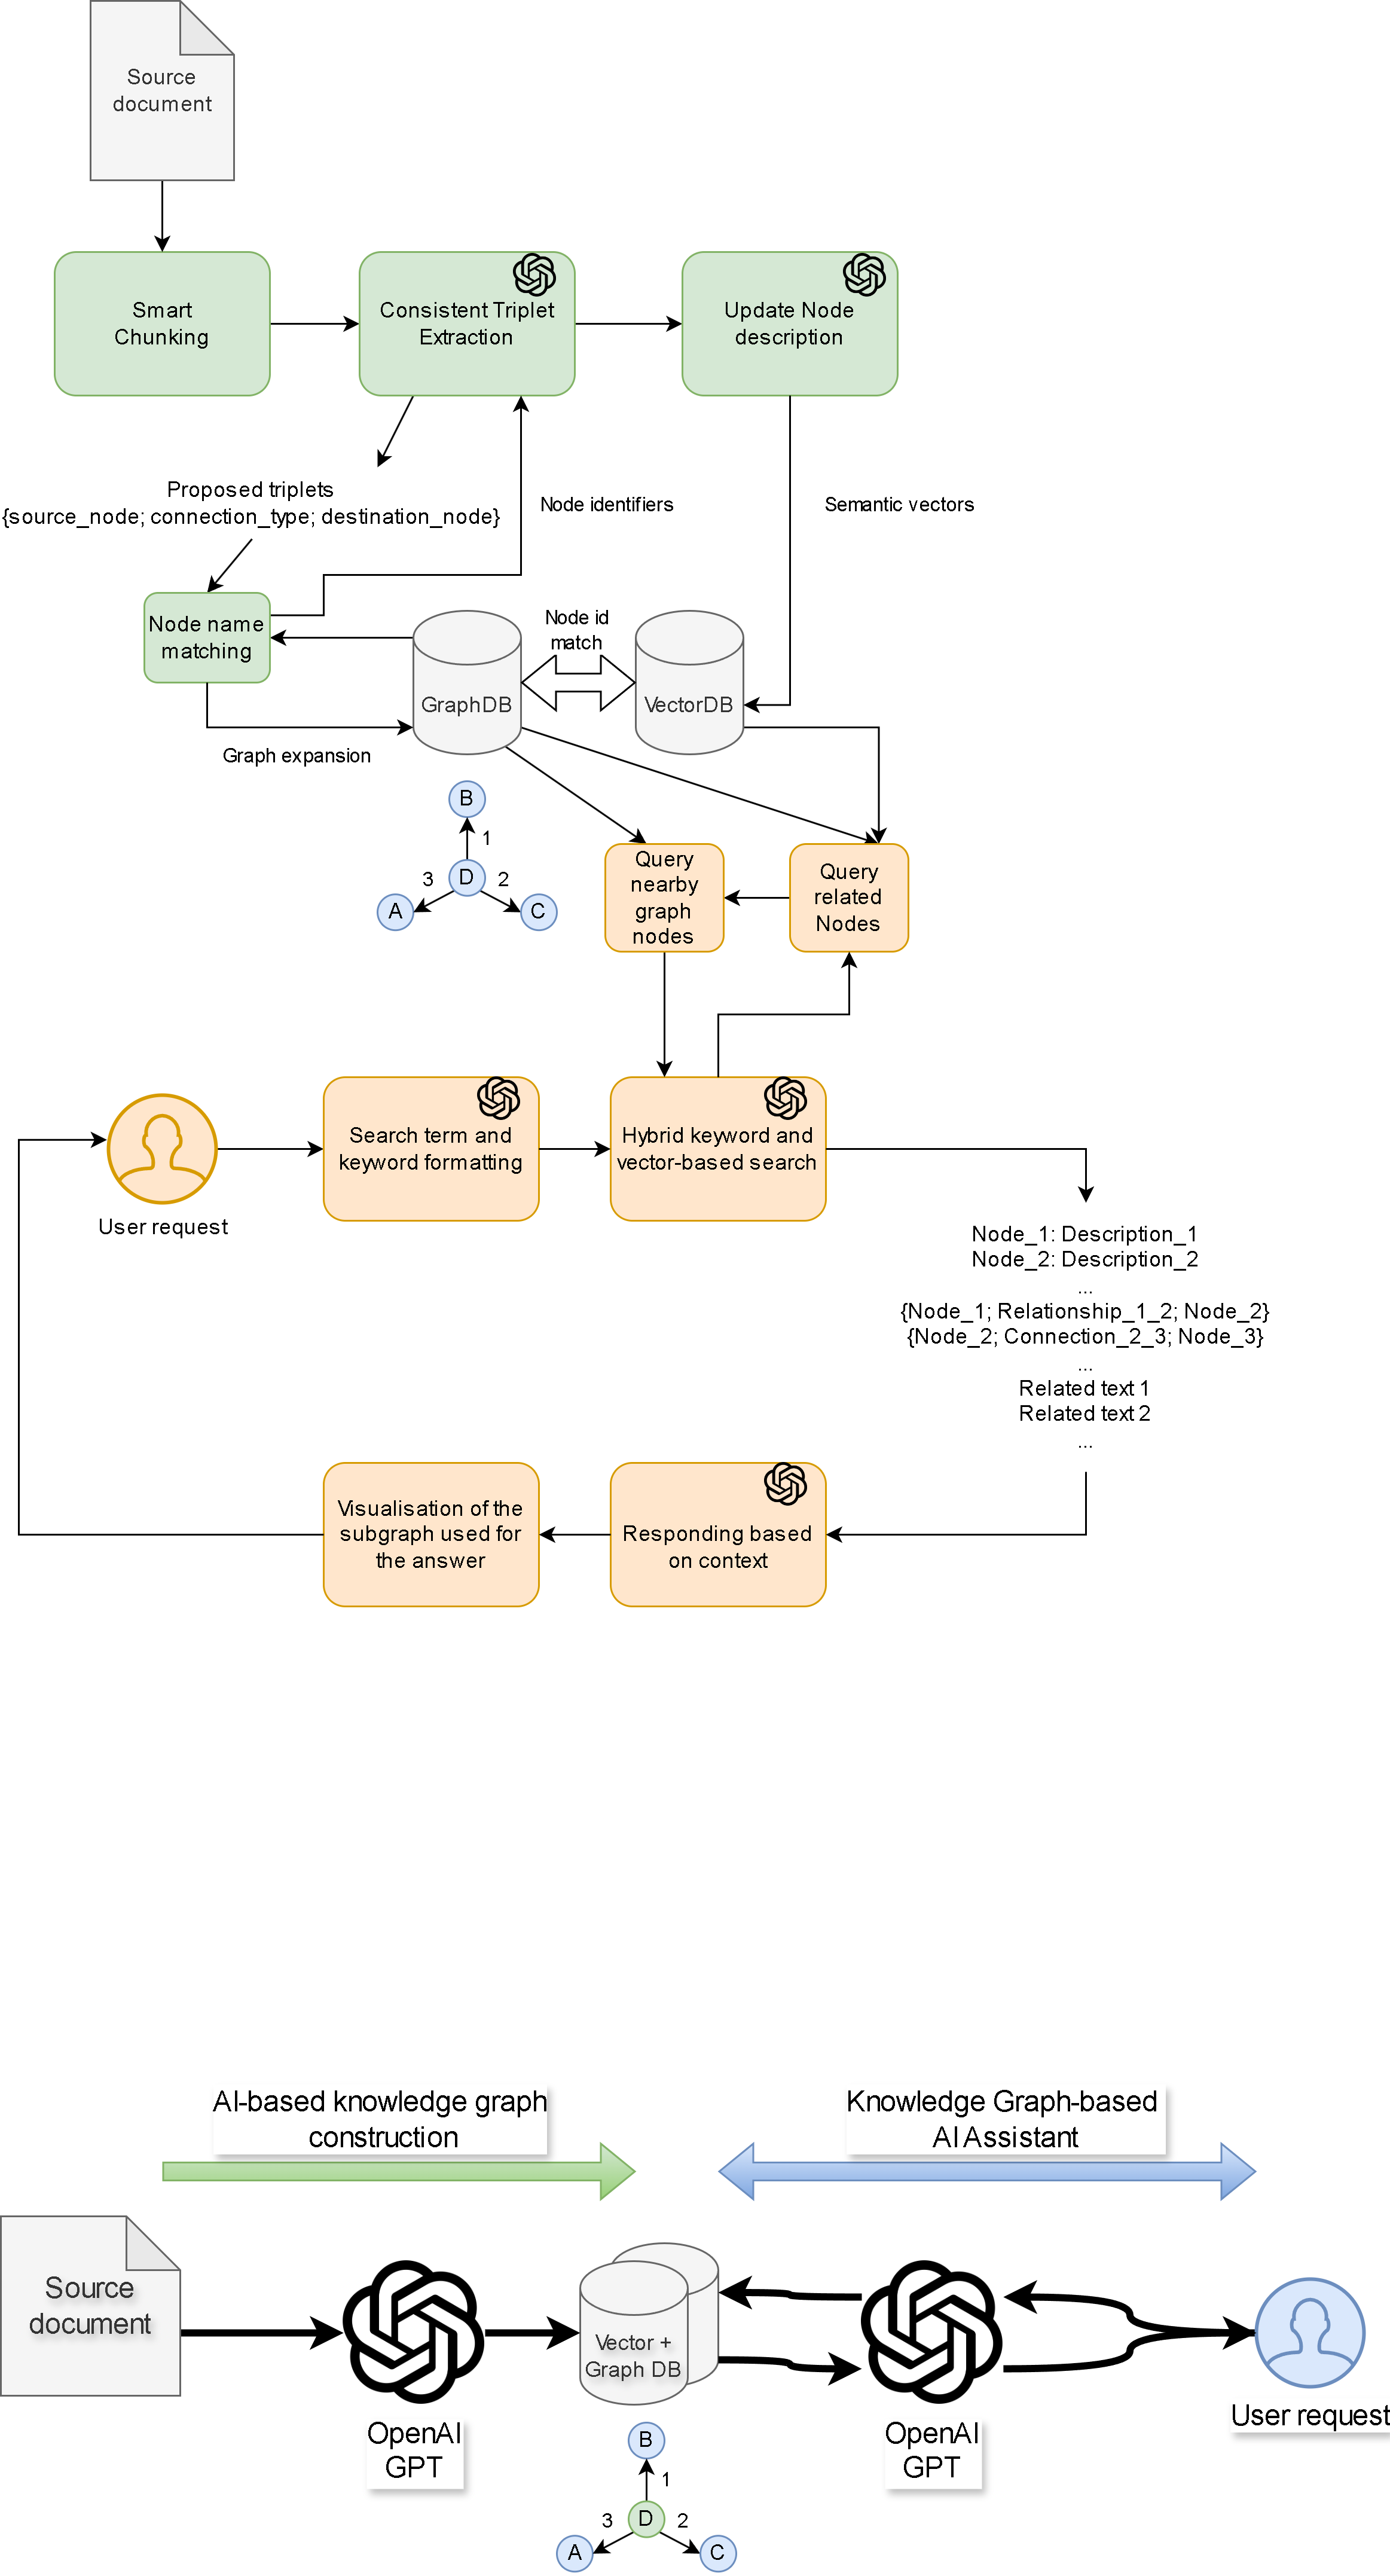

### Install all required packages

In [ ]:
!pip install llama-index==0.11.13 -q
!pip install llama-index-llms-openai==0.2.9 -q
!pip install llama-index-embeddings-openai==0.2.5 -q
!pip install llama-index-readers-file==0.2.2 -q
!pip install nebula3-python==3.8.2 -q
!pip install nebulagraph-lite==0.2.5 -q
!pip install ipython-ngql==0.14.3 -q
!pip install pyvis==0.3.2 -q
!pip install ipython==7.34.0 -q
!pip install chromadb==0.5.7 -q
!pip install PyPDF2==3.0.1 -q
!pip install nltk==3.9.1 -q

###

### Import everything which is necessary

In [ ]:
import os
import tiktoken
from google.colab import userdata

from llama_index.core import Settings
from llama_index.core.prompts import ChatMessage, PromptTemplate, ChatPromptTemplate
from llama_index.core.base.llms.types import (
    ChatMessage,
    MessageRole,
)

from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.openai import OpenAIEmbedding

from llama_index.llms.openai import OpenAI

from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.readers.file import PDFReader
from llama_index.core.memory import ChatMemoryBuffer

from pyvis.network import Network
from pyvis.options import Layout
from IPython.display import IFrame, HTML

import chromadb
from chromadb.utils import embedding_functions

from random import shuffle
import nltk
import json

import requests
from PyPDF2 import PdfReader, PdfWriter
from io import BytesIO
import httpx
from datetime import datetime

### Initializing NebulaGraph Database, more info about the database can be found on [NebulaGraph](https://docs.nebula-graph.io/3.8.0/)
The documentation for the NGQL query language used by NebulaGraph can be found on [NebulaGraph Docs](https://docs.nebula-graph.io/3.0.0/3.ngql-guide/1.nGQL-overview/1.overview/).

You can find relationship related queries in the **Graph Patterns** section of the documentation

In [ ]:
from nebulagraph_lite import nebulagraph_let as ng_let

n = ng_let()

# This takes around 5 mins
n.start()

In [ ]:
%load_ext ngql
%config IPythonNGQL.ngql_result_style="raw"


In [ ]:
%ngql --address 127.0.0.1 --port 9669 --user root --password nebula

[OK] Connection Pool Created


ResultSet(keys: ['Name'], values: ["basketballplayer"])

In [ ]:
class NebulaHandler:
    def __init__(self, space_name):
        """
          Initializes the NebulaHandler object and specify space name.

          Args:
              space_name (str): The name of the space to initialize and switch to.
        """
        self.space_name = space_name

    def switch_space(self, space_name):
        """
          Switches the space in the NebulaGraph database.

          Args:
              space_name (str): The name of the space to switch to.
        """
        self.space_name = space_name

    def recreate_space(self):
        """
          Recreates the specified space in the NebulaGraph database.
          This includes dropping:
          - the existing space
          - creating a new space,
          - defining the entity and relationship structure.
        """
        query = f'''
            DROP SPACE IF EXISTS {self.space_name};
            CREATE SPACE {self.space_name}(partition_num=1, replica_factor=1, vid_type=INT64);
            USE {self.space_name};
            CREATE TAG entity(name string, description string);
            CREATE EDGE relationship(relationship string);
            CREATE TAG INDEX entity_name_index ON entity();
            CREATE EDGE INDEX relationship_index ON relationship();
        '''
        %ngql {query}


    def get_max_entity_idx(self):
        """
          Retrieves the maximum entity ID in the current space, used for assigning new entity IDs.

          Returns:
              int: The highest entity ID or 0 if there are no entities.
        """
        query = f'''
            USE {self.space_name};
            MATCH (v:entity) RETURN id(v) AS id ORDER BY id DESC LIMIT 1
        '''
        result = %ngql {query}
        entity_idx = result.column_values('id')
        if len(entity_idx)>0:
            entity_idx = entity_idx[0].as_int()
        else:
            entity_idx = 0

        return entity_idx

    def insert_entity(self, entity_name, entity_description, entity_idx = None):
        """
          Inserts a new entity with the given name and description into the space.
          If no entity_idx is provided, a new one is generated.

          Args:
              entity_name (str): The name of the entity.
              entity_description (str): A description of the entity.
              entity_idx (int, optional): The ID to assign to the entity. If not provided, auto-generated.

          Returns:
              int: The ID of the inserted entity.
        """
        if entity_idx is None:
            entity_idx = str(self.get_max_entity_idx()+1)

        entity_name = entity_name.replace("'", "\\'")
        entity_description = entity_description.replace("'", "\\'")

        query = f'''
            USE {self.space_name};
            INSERT VERTEX entity(name, description) VALUES {entity_idx}:("{entity_name}", "{entity_description}");
        '''
        resp = %ngql {query}

            #print(entity_idx, entity_name)
        # print(resp.__dict__)

        if not resp._resp.error_code:
          print("Insert operation successful!")
        else:
          print("Error occurred during insert:", resp)

        return entity_idx

    def insert_relationship(self, src_entity_idx, dst_entity_idx, relationship):
        """
          Inserts a relationship (edge) between two entities in the space.

          Args:
              src_entity_idx (int): The ID of the source entity.
              dst_entity_idx (int): The ID of the destination entity.
              relationship (str): The relationship description between the two entities.
        """
        query = f'''
              USE {self.space_name};
              INSERT EDGE relationship(relationship) VALUES {src_entity_idx}->{dst_entity_idx}:('{relationship}')
        '''
        relationship = relationship.replace("'", "\\'")
            #print(src_entity_idx, dst_entity_idx, relationship)
            #print(resp.__dict__)
        resp = %ngql {query}
        if not resp._resp.error_code:
          print("Insert operation successful!")
        else:
          print("Error occurred during insert:", resp)

    def upsert_entity_relationship(self, src_name, src_description, dst_name, dst_description, relationship):
        """
          Upserts (inserts or updates) two entities and their relationship in the space.

          Args:
              src_name (str): The name of the source entity.
              src_description (str): The description of the source entity.
              dst_name (str): The name of the destination entity.
              dst_description (str): The description of the destination entity.
              relationship (str): The relationship description between the two entities.

          Returns:
              tuple: A tuple containing the IDs of the source and destination entities.
        """
        src_entity_idx = self.get_id_by_name(src_name)
        dst_entity_idx = self.get_id_by_name(dst_name)
        src_entity_idx = self.insert_entity(src_name, src_description, src_entity_idx)
        dst_entity_idx = self.insert_entity(dst_name, dst_description, dst_entity_idx)
        self.insert_relationship(src_entity_idx, dst_entity_idx, relationship)
        return src_entity_idx, dst_entity_idx


    def get_id_by_name(self, entity_name):
        """
          Retrieves the ID of an entity by its name.

          Args:
              entity_name (str): The name of the entity.

          Returns:
              int or None: The ID of the entity, or None if the entity does not exist.
        """
        query = f'''
            USE {self.space_name};
            MATCH (v:entity) WHERE v.entity.name == "{entity_name}" RETURN id(v) AS id
        '''
        entity_name = entity_name.replace("'", "\\'")
        resp = %ngql {query}
        if len(resp.column_values("id"))>0:
            entity_idx = str(resp.column_values("id")[0].as_int())
        else:
            entity_idx = None

        print(entity_name, "found under idx", entity_idx)
        return entity_idx

    def get_data_by_id(self, entity_idx):
        """
          Retrieves all data for an entity by its ID.

          Args:
              entity_idx (int): The ID of the entity.

          Returns:
              dict: A dictionary of entity data.
        """
        query = f'''
            USE {self.space_name};
            MATCH (v:entity) WHERE id(v) == {entity_idx} RETURN v
        '''

        resp = %ngql {query}
        entity_data = resp.dict_for_vis()["nodes_dict"]
        return entity_data

    def get_all_data_in_hops(self, entity_name_list, hops):
        """
          Retrieves all entities and relationships within a certain number of hops from the given entity names.

          Args:
              entity_name_list (list): A list of entity names to search from.
              hops (int): The number of hops to traverse relationships.

          Returns:
              tuple: A tuple containing the nodes and edges dictionaries.
        """
        # print("Getting data for")
        # print("entity_name_list", entity_name_list)

        query = f'''
            USE {self.space_name};
            MATCH p=(v:entity)-[r*1..{hops}]-(v1:entity) WHERE v.entity.name IN {entity_name_list} RETURN p
        '''
        entity_name_list = [name.replace("'", "\\'") for name in entity_name_list]
        resp = %ngql {query}
        # print(resp.__dict__)
        data = resp.dict_for_vis()
        #print(data)

        return data["nodes_dict"], data["edges_dict"]

    def get_all_node_names(self):
        """
          Retrieves the names of all nodes (entities) in the space.

          Returns:
              list: A list of all node names.
        """
        query = f'''
            USE {self.space_name};
            MATCH (v:entity) RETURN v.entity.name
        '''

        resp = %ngql {query}
        node_names = resp.column_values("v.entity.name")

        if len(node_names) == 0:
            names = []
        else:
            try:
                names = [n.as_string() for n in node_names]
            except:
                names = []

        #print(names)
        return names


    def get_description_by_name(self, entity_name):
        """
          Retrieves the description of an entity by its name.

          Args:
              entity_name (str): The name of the entity.

          Returns:
              str or None: The description of the entity, or None if not found.
        """
        query = f'''
            USE {self.space_name};
            MATCH (v:entity) WHERE v.entity.name == "{entity_name}" RETURN v.entity.description
        '''
        entity_name = entity_name.replace("'", "\\'")
        resp = %ngql {query}
        #print("getting",entity_name, "description\n",resp.__dict__)
        entity_description = resp.column_values("v.entity.description")
        if len(entity_description) > 0:
            entity_description = entity_description[0].as_string()
        else:
            entity_description = None

        return entity_description

    def get_full_graph(self):
        """
          Retrieves the full graph of all entities and relationships in the space.

          Returns:
              tuple: A tuple containing the nodes and edges dictionaries.
        """
        query = f'''
            USE {self.space_name};
            MATCH p=(v:entity)-[r]->(v1:entity) RETURN p
        '''

        resp = %ngql {query}
        data = resp.dict_for_vis()

        return data["nodes_dict"], data["edges_dict"]

### Initializing Vector Database
Because of the limitations of Google Colab we use [ChromaDB](https://www.trychroma.com/). But for this purpose, [Weaviate](https://weaviate.io/) is a better alternative if you are using it locally or from the cloud.

In [ ]:
class ChromaHandler:

    def __init__(self, collection_name):
        """
        Initializes the ChromaHandler object and switches to the specified collection.

        Args:
            collection_name (str): The name of the collection to initialize and switch to.
        """
        self.collection_name = collection_name
        self.switch_collection(collection_name)

    def embedding_function(self):
        """
        Returns the embedding function for Chroma.
        Here OpenAI embeddings used, could be changed to other embeddings.

        Returns:
            embedding_functions.OpenAIEmbeddingFunction: The embedding function for Chroma.
        """
        openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=API_TOKEN,
                model_name=OPENAI_EMBEDDING_MODEL_NAME,
            )
        return openai_ef

    def get_all_collections_name(self):
        """
        Retrieves the names of all collections in the Chroma database.

        Returns:
            list: A list of collection names.
        """
        collections = chromadb.Client().list_collections()
        collections = [c.name for c in collections]
        return collections


    def switch_collection(self, collection_name):
        """
        Switches the collection in the Chroma database.

        Args:
            collection_name (str): The name of the collection to switch to.
        """
        self.collection_name = collection_name
        client = chromadb.Client()

        if self.collection_name in self.get_all_collections_name():
            self.collection = client.get_collection(collection_name)
        else:
            self.recreate_collection(collection_name)

    def recreate_collection(self, collection_name):
        """
        Recreates the specified collection in the Chroma database.

        Args:
            collection_name (str): The name of the collection to recreate.
        """
        client = chromadb.Client()
        if self.collection_name in self.get_all_collections_name():
            client.delete_collection(collection_name)
        client.create_collection(collection_name, embedding_function=self.embedding_function())


    def upsert_entity(self, entity_name, entity_description, vid, text):
      """
        Upserts (inserts or updates) an entity into the specified collection with its metadata.

        Args:
            entity_name (str): The name of the entity.
            entity_description (str): A description of the entity to be stored.
            vid (str): The unique ID of the entity.
            text (str): Additional text metadata related to the entity.
        """
      client = chromadb.Client()
      collection = client.get_collection(self.collection_name)
      collection.upsert(
              documents=[entity_description],
              metadatas=[{"name": entity_name, "texts": text}],
              ids=[vid]
          )
      result = collection.get(where={"name": entity_name})

      # print(result)


    def search_entity_by_description(self, query, top_k=5):
        """
        Searches for entities in the collection by their description and retrieves metadata.

        Args:
            query (str): The query string to search for in the entity descriptions.
            top_k (int, optional): The maximum number of results to return. Defaults to 5.

        Returns:
            List[dict]: A list of objects, each containing entity details (vid, name, description, texts).
        """
        client = chromadb.Client()
        collection = client.get_collection(self.collection_name)
        results = collection.query(
            query_texts=[query],
            n_results=top_k,
            include=["documents", "metadatas"])

        objects = []

        for index, _ in enumerate(results["documents"][0]):
            data = {"vid": results['ids'][0][index], "name": results["metadatas"][0][index]["name"], "description": results["documents"][0][index], "texts": results["metadatas"][0][index]["texts"]}
            objects.append(data)
        return objects

### Get the document we will use. For this example we used the writing of Leopold Aschenbrenner titled [**Situational Awareness**](https://situational-awareness.ai/) and get a 30 page chunk from it.

You will see that this book or wiriting is about the future, how the models will develop, and how these models will perform. These concepts are theoretical and these are the guesses of the author for the future.

In [ ]:
def download_and_extract_pdf(url, output_filename, start_page=46, page_count=30):
    response = requests.get(url)
    if response.status_code == 200:
        pdf_data = BytesIO(response.content)
        reader = PdfReader(pdf_data)

        writer = PdfWriter()

        total_pages = len(reader.pages)

        start_index = start_page - 1
        end_index = min(start_index + page_count, total_pages)

        for page_num in range(start_index, end_index):
            writer.add_page(reader.pages[page_num])

        with open(output_filename, "wb") as output_pdf:
            writer.write(output_pdf)

        print(f"Extracted pages {start_page}-{end_index} from the PDF and saved to {output_filename}.")
    else:
        print(f"Failed to download the PDF. Status code: {response.status_code}")

# Here you can add your own PDF URL if zou want to try out other documents
pdf_url = "https://situational-awareness.ai/wp-content/uploads/2024/06/situationalawareness.pdf"
output_pdf = "KG_RAG.pdf"
download_and_extract_pdf(pdf_url, output_pdf)

Extracted pages 46-75 from the PDF and saved to KG_RAG.pdf.


### Initialize the models we will use

- ChatModel: GPT4-o-mini, this is a cost-effective version of GPT-4o
- Embedding Model: text-embedding-3-small from OpenAI
- Tokenizer model: using GPT-4o with tiktoken library which is a fast BPE tokenizer using OpenAI models

You will need an API Token From the OpenAI API website, and also around 5 dollars uploaded to your account ([Guide for making an OpenAI API account](https://help.noteplan.co/article/207-set-personal-openai-api-key))

I used the Google Colab **Secret** feature to store API token and to use it in code. ([Here is a tutorial how to use Colab Secrets](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75))

You must set the ***OPENAI_API_KEY*** environment variable to you API TOKEN!!!!!


### If you are not running this on colab, please set the ***OPENAI_API_KEY*** to you API KEY

In [ ]:
API_TOKEN = userdata.get('OPEN_AI_KEY')
os.environ['OPENAI_API_KEY'] = API_TOKEN

In [ ]:
OPENAI_CHAT_MODEL_NAME="gpt-4o-mini" # Change this to use a different model
OPENAI_EMBEDDING_MODEL_NAME="text-embedding-3-small"

In [ ]:
def init_llms():
    Settings.llm = OpenAI(temperature=0.3, model=OPENAI_CHAT_MODEL_NAME)
    Settings.embed_model = OpenAIEmbedding(model_name=OPENAI_EMBEDDING_MODEL_NAME, mode="similarity")
    Settings.tokenizer = tiktoken.encoding_for_model(OPENAI_CHAT_MODEL_NAME)

init_llms()

### Let's destroy our PDF into semantically relevant chunks

The sentences of the PDF are split and embedded in groups of 3. Then the embedding changes (that capture the semantics, the meaning of the given sentence group) are computed over all consecutive sentence groups. The highest changes (upper 95 percentile) are selected as chunk boundaries. This is done to avoid splitting corresponding sentences into different chunks.
This chunking method is somewhat crude as layout is ignored and sentences are split using regex only.
For more details see: https://www.youtube.com/watch?v=8OJC21T2SL4&t=1933s

In [ ]:
def parse_pdf(document_path):
    """
    Parses a PDF document and returns a list of nodes extracted from the document.

    Args:
        document_path (str): The path to the PDF document.

    Returns:
        list: A list of nodes extracted from the document.
    """
    documents = PDFReader().load_data(document_path)

    splitter = SemanticSplitterNodeParser(
        buffer_size=5, breakpoint_percentile_threshold=95, embed_model=Settings.embed_model
    )
    nodes = splitter.get_nodes_from_documents(documents)
    for node in nodes:
        node.text = node.text.replace("“", '"').replace("”", '"').replace("‘", "'").replace("’", "'")
    return nodes

In [ ]:
# Define the spce_name used in the Databases
space_name = "KG_RAG"

In [ ]:

docs = parse_pdf(output_pdf)

print(f"Extracted {len(docs)} chunks from {output_pdf}")
vec_db = ChromaHandler(space_name)
graph_db = NebulaHandler(space_name)

vec_db.switch_collection(space_name)
graph_db.switch_space(space_name)

vec_db.recreate_collection(space_name)
graph_db.recreate_space()

Extracted 60 chunks from KG_RAG.pdf


### Defining prompt templates.

With GPT-4o-mini JSON was used, to make the communication more structured. (You will see the resaon below). It is good practice to use only JSON for communcation (JSON goes in, JSON goes out) because if we want structured data as output, JSON object is easy-to-process from code.

For using JSON with a model shcemas can be added to the model, but from experience, an excample JSON object what we want as output works better tha using shcemas.

Here OpenAI presents the Structured output case (using schema) and JSON mode case [Schema and JSON mode](https://platform.openai.com/docs/guides/structured-outputs/how-to-use?context=ex1)


We add the instructions and the JSON example in the system prompt, and only providing a JSON as a user prompt.

In [ ]:
extract_triplets_chat_templ = ChatPromptTemplate(message_templates=[
    ChatMessage(content="""Given a text chunk from a document extract up to {max_knowledge_triplets} and not more knowledge triplets in the form of (subject, predicate, object).
Stopwords should be avoided. Provide the triples as a JSON object along with a short description of the subject and object entities. Descriptions could be longer than the example provided.
Use English regardless of the input data.

Example:
Text: Philz is a coffee shop founded in 1982 in Berkeley. The café specializes in handcrafted coffee.

Response example:
{{
   "triplets": [
    {{
        "subject": {{"name": "Philz", "description": "The name of a coffee shop"}},
        "predicate": "type of business",
        "object": {{"name": "coffee shop", "description": "A place specializing in serving coffee"}}
    }},
    {{
        "subject": {{"name": "Philz", "description": "The name of a coffee shop"}},
        "predicate": "located in",
        "object": {{"name": "Berkeley", "description": "A city in California"}}
    }},
    {{
        "subject": {{"name": "Philz", "description": "The name of a coffee shop"}},
        "predicate": "founded in",
        "object": {{"name": "1982", "description": "A year, date"}}
    }},
    {{
        "subject": {{"name": "Philz", "description": "The name of a coffee shop"}},
        "predicate": "specializes in",
        "object": {{"name": "handcrafted coffee", "description": "Coffee made by hand, generally of high quality"}}
    }}
  ]
}}""", role="system"),
    ChatMessage(content="{text}", role="user")
]
)



In [ ]:
refine_triplet_chat_templ = ChatPromptTemplate(message_templates=[
    ChatMessage(content="""Your task is to decide if the knowledge triplet extracted from a document could be refined by finding similar nodes in the graph. Use a proper JSON format!
    Use English regardless of the input data.
Example query:
{{
    "document": "Philz is a coffee shop founded in 1982 in Berkeley. The café specializes in handcrafted coffee.",
    "triplet": {{
        "subject": "Philz",
        "predicate": "type of business",
        "object": "coffee shop"
    }},
    "new_nodes": [
        {{
            "entity": "Philz",
            "description": "The name of a coffee shop."
        }},
        {{
            "entity": "coffee shop",
            "description": "A place specializing in serving coffee."
        }}
    ],
    "existing_nodes": [
        {{
            "entity": "Philz Coffee Shop",
            "description": "A coffee shop located in Berkeley."
        }},
        {{
            "entity": "Berkeley",
            "description": "A city in California."
        }},
        {{
            "entity": "1982",
            "description": "A year."
        }}
    ]
}}
Example response:
{{
    "reasoning": "'Philz' is likely a shorthand for 'Philz Coffee Shop.' The coffee shop node doesn't yet exist in the graph in a general sense.",
    "refined_triplet": {{
        "subject": {{
            "name": "Philz Coffee Shop",
            "description": "A coffee shop located in Berkeley, often referred to as 'Philz.'"
        }},
        "predicate": "type of business",
        "object": {{
            "name": "coffee shop",
            "description": "A place specializing in serving coffee."
        }}
    }}
}}

Provide a reasoning for your decision and suggest a refined triplet if necessary using the existing nodes, or keeping the new nodes if they are not present in the graph with a good enough precision.
If you select an already existing node extend the description of that node with the new information provided in the document.""", role="system"),
ChatMessage(content="{datajson}", role="user")
]
)



In [ ]:
question_forming_chat_templ = ChatPromptTemplate(message_templates=[
    ChatMessage(content="""Given the user's last request extract a list of at most {max_entities} entities/keyphrases that the user is interested in.
In a proper JSON format:
Generate a standalone question resolving any references to the provided chat history.
Generate a hypothetical descriptions for the entities/keyphrases.
Generate a hypothetical answer to the question.
Use English regardless of the input data.

Example input:
{{"chat": [
  {{"role": "user", "content": "Hi! I'd like to find a café in Berkeley."}},
  {{"role": "assistant", "content": "There are several cafés in Berkeley. What kind of coffee are you looking for?"}},
  {{"role": "user", "content": "I'm specifically looking for original black coffee."}}] }}

Example output:
{{
  "question": "Where can I find a store that sells original black coffee in Berkeley?",
  "phrases": [
      {{"entity": "café", "description": "A place that specializes in serving coffee"}},
      {{"entity": "Berkeley", "description": "A city in California"}},
      {{"entity": "original black coffee", "description": "A type of coffee that is not mixed with other varieties and contains no added flavors."}}
  ],
  "hypothetical_answer": "One of the most well-known cafés selling original black coffee is Philz Café in Berkeley."}}
}}

Use null for all the parameters if the user just says hi, or there is no information that you could extract from the conversation.""", role="system"),
ChatMessage(content="{historyjson}", role="user")
]
)


bot_prefix_chat_templ = ChatPromptTemplate(message_templates=[
    ChatMessage(content="""You are a helpful assistant. You answer the user's question based on the context provided here.
Do not make up data, ground your answers in the context.
The context contains a set of document chunks, knowledge graph nodes and knowledge graph connections. Use these to answer the question.
Do not mention this knowledge graph directly, use fluent natural language instead.
Use English regardless of the input data.

### Context ###
{context_info}""", role="system"),
ChatMessage(content="{starter_message}", role="assistant")
])

bot_prefix_chat_without_context_templ = ChatPromptTemplate(message_templates=[ChatMessage(content="""You are a helpful assistant. You answer the uses's question. Do not provide any intermediate
step thinking or reasoning just the answer for the question""", role="system"),
    ChatMessage(content="{starter_message}", role="assistant")
])


### Defining Tokencheker class

This class will use a tokenizer to limit the number of input tokens to the ***max_tokens*** treshold.

This is important in cases where the chun text or the prompt text is too long and does not fit the context window then need to drop the extra tokens.

In [ ]:
class TokenChecker:
    def __init__(self, model_name):
        self.tokenizer = tiktoken.encoding_for_model(model_name)

    def restrict(self, input_text, max_tokens, return_len=False):
        tokens = self.tokenizer.encode(input_text)
        restricted_tokens = tokens[:max_tokens]
        restricted_text = self.tokenizer.decode(restricted_tokens)

        if return_len:
            return restricted_text, len(tokens)
        else:
            return restricted_text


In [ ]:
embedding_tokenizer = TokenChecker(OPENAI_EMBEDDING_MODEL_NAME)
chat_tokenizer = TokenChecker(OPENAI_CHAT_MODEL_NAME)

### Defining Triplet extarcting and triplet refining functions

####Triplet extraction   
The chunks are then consecutively processed to extract
`subject-predicate-object` triplets. Each node of the triplets is paired up with a corresponding description.

####Consistency check   
Since the triplet extraction handles each node separately finding previously extracted nodes and merging them with the currently proposed triplets is necessary. Each triplet is checked for consistency with the existing graph. If a node's name is similar (2 characters away) from an existing node they are automatically considered as an alternative. This set of alternative, already existing nodes is then expanded via a similarity search in the node description embedding space (regular retrieval of the top 5 most similar nodes). Then OpenAI is prompted with the alternative node information and the new proposed triplet, after a short reasoning the LLM (used in JSON mode) decides if any of the nodes in the new triplet should be merged with an existing alternative node. If nodes are merged the description of the existing node is updated to reflect the new information. This is done to avoid duplicates and to keep the graph clean. This method is "experimental" as there is no prior method that achieves the same.

In [ ]:
def extract_triplets(num_triplets, text):
    """
    Extracts knowledge triplets from a given text.

    Args:
        num_triplets (int): The number of knowledge triplets to extract.
        text (str): The text from which to extract the knowledge triplets.

    Returns:
        str: The extracted knowledge triplets.
    """

    text = embedding_tokenizer.restrict(text, 120000)

    messages = extract_triplets_chat_templ.format_messages(max_knowledge_triplets=num_triplets,
                                                        text=text)

    resp = Settings.llm.chat(
                            messages=messages,
                            temperature=0.0,
                            max_tokens=16000,
                            response_format={ "type": "json_object" },
                            timeout = httpx.Timeout(500)
                            )

    data_dict = json.loads(resp.message.content)
    nodes = [{"subject":t["subject"]["name"], "predicate":t["predicate"], "object":t["object"]["name"]} for t in data_dict["triplets"]]

    descriptions = {t["subject"]["name"]:t["subject"]["description"] for t in data_dict["triplets"]}
    descriptions.update({t["object"]["name"]:t["object"]["description"] for t in data_dict["triplets"]})

    return nodes, descriptions

In [ ]:
def find_similar_graph_nodes(description, name, edit_distance_threshold=2, max_edit_distance_based = 5, topk_vectors=5):
    similar_names = graph_db.get_all_node_names()
    print(similar_names)

    close_matches = []
    for similar_name in similar_names:
        if nltk.edit_distance(similar_name, name) <= edit_distance_threshold:
            close_matches.append(similar_name)

    shuffle(close_matches)
    if len(close_matches) > max_edit_distance_based:
        close_matches = close_matches[:max_edit_distance_based]

    asdf = vec_db.search_entity_by_description(description, top_k=topk_vectors)
    for obj in asdf:
        close_matches.append(obj["name"])

    return close_matches

def llm_refine_triplet(src, dst, relationship, src_desc, dst_desc, text):
    similar_src = find_similar_graph_nodes(src_desc, src)
    similar_dst = find_similar_graph_nodes(dst_desc, dst)

    similars = similar_src + similar_dst

    descriptions = []
    to_remove = []
    for s in similars:
        if sd := graph_db.get_description_by_name(s) is not None:
            descriptions.append(sd)
        else:
            to_remove.append(s)

    for r in to_remove:
        similars.remove(r)

    data = {}
    data["document"] = text
    data["triplet"] = {"subject": src, "predicate": relationship, "object": dst}
    data["new_nodes"] = [{"entity": src, "description": src_desc}, {"entity": dst, "description": dst_desc}]
    data["existing_nodes"] = [{"entity": similar, "description": description} for similar, description in zip(similars, descriptions)]

    datatxt = json.dumps(data, ensure_ascii=False)

    datatxt = embedding_tokenizer.restrict(datatxt, 120000)

    messages = refine_triplet_chat_templ.format_messages(datajson=datatxt)
    resp = Settings.llm.chat(messages=messages,
                            temperature=0.0,
                            max_tokens=16000,
                            response_format={ "type": "json_object" }
                            )

    data = json.loads(resp.message.content)

    triplet_dict = {"subject": data["refined_triplet"]["subject"]["name"],
                    "predicate": data["refined_triplet"]["predicate"],
                    "object": data["refined_triplet"]["object"]["name"]}

    description_dict = {data["refined_triplet"]["subject"]["name"]: data["refined_triplet"]["subject"]["description"],
                        data["refined_triplet"]["object"]["name"]: data["refined_triplet"]["object"]["description"]}

    return triplet_dict, description_dict



In [ ]:
max_triplets = 10

### Building graph

Be aware that this cell is running for a longer time. for 60 Chunks it takes around 23-25 mins.

In [ ]:

for i, doc in enumerate(docs):
    try:
        print(f"Processing chunk {i}\n from", len(docs))
        # extracting triplets
        triplets, descriptions = extract_triplets(max_triplets, doc.text)
        print(f"Extracted {len(triplets)} triplets from the chunk")
        for triplet in triplets:
            try:
                # refine triplets based on the previously processed nodes
                final_triplet, final_descriptions = llm_refine_triplet(triplet["subject"], triplet["object"], triplet["predicate"],
                                descriptions[triplet["subject"]], descriptions[triplet["object"]], doc.text)
                # update entities both in graph and vector database



                subj_desc, subj = final_descriptions[final_triplet["subject"]].replace("'", " "), final_triplet["subject"].replace("'", " ")
                obj_desc, obj = final_descriptions[final_triplet["object"]].replace("'", " "), final_triplet["object"].replace("'", " ")
                predi = final_triplet["predicate"].replace("'", " ")

                subj_vid, obj_vid = graph_db.upsert_entity_relationship(subj, subj_desc,obj, obj_desc, predi)

                vec_db.upsert_entity(subj, subj_desc, subj_vid, doc.text)
                vec_db.upsert_entity(obj, obj_desc, obj_vid, doc.text)
            except Exception as e:
                print(f"Error processing triplet {triplet}: {e}")
                print("Skipping...")
                continue
    except Exception as e:
        print(f"Error processing chunk {i}: {e}")
        print("Skipping...")
        continue

print("Graph created successfully")


### Function for rendering the graph based on nodes, edges and source_nodes (which are the nodes got from the vector similarity search from the query)

Here is the [Documentation for Pyvis](https://pyvis.readthedocs.io/en/latest/documentation.html)

In [ ]:
def get_precise_timestamp():
    # Get the current datetime
    now = datetime.now()
    # Format the timestamp with microseconds
    formatted_timestamp = now.strftime("%Y-%m-%d-%H-%M-%S-%f")
    return formatted_timestamp[:-3]  # Truncate to milliseconds

In [ ]:

def create_renderer(edge_dict, node_dict, source_name_list = None):
    g = Network(
        notebook=True,
        directed=True,
        cdn_resources="in_line",
        height="700px",
        width="100%",
    )

    for k, v in node_dict.items():
        name = v["props"]["name"]
        description = v["props"]["description"]
        color="blue"
        if source_name_list is not None:
            if name in source_name_list:
                color = "green"

        g.add_node(k, label=name, color=color, title=description)

    for k, v in edge_dict.items():
        src = v["src"]
        dst = v["dst"]
        relationship = v["props"]["relationship"]
        g.add_edge(src, dst, label=relationship)


    g.repulsion(
        node_distance=300,
        central_gravity=0.13,
        spring_length=250,
        spring_strength=0.1,
        damping=0.12,
    )

    return g

def render_graph(edge_dict, node_dict, source_name_list = None):
    g = create_renderer(edge_dict, node_dict, source_name_list)
    time_stamp = get_precise_timestamp()
    g.show(f"graph_{time_stamp}.html")
    return HTML(filename=f"graph_{time_stamp}.html")

In [ ]:
node_dict, edge_dict = graph_db.get_full_graph()
render_graph(edge_dict, node_dict)

### Extracts entities with descriptions from the user query and a hypothetical answer.
Here, the LLM (used in JSON mode) is one-shot prompted to format the last user message into a standalone question that is general enough and resolves ambiguities and references using the chat history. Then the model should extract at most 5 entities (node candidates) from the question and provide 'hypothetical' descriptions for them. Finally a hypothetical general answer is generated which is not used in the current implementation but if someone wants to extend this retrieving process, you can include the hypothetical answer as well. :D

In [ ]:
def form_question(chat_memory):
    """ Return a question, HyDE-like hypothetical answer and search phrases with hypothetical descriptions based on the chat history.

    Args:
        user_message: The user's message.

    Returns:
        tuple: A tuple containing the question, hypothetical answer and search phrases with hypothetical descriptions
    """

    history_dict = [{"role":m.role, "content":m.content} for m in chat_memory.get_all()]

    history_json = {"chat_history": history_dict}
    messages = question_forming_chat_templ.format_messages(historyjson=json.dumps(history_json, ensure_ascii=False),
                                                           max_entities=5)
    resp = Settings.llm.chat(messages=messages,
                            temperature=0.0,
                            max_tokens=16000,
                            response_format={ "type": "json_object" }
                            )

    data = json.loads(resp.message.content)

    return data["question"], data["hypothetical_answer"], data["phrases"]


# Retrieving daata based on the extracted entities from the user query and chat history

The retrieval procedure first selects "source nodes" that fulfill at least one of the following criteria:   
 (1) The name of the entity matches a graph node's name closely.   
 (2) The hypothetical embedding is similar to a graph node.   
Rule (1) is checked using exact matching while for rule (2) we execute a classic retrieval on the vector database returning the top 5 most similar nodes based on their description for each entity extracted during query forming.   
Finally the graph is queried, we extract all triplets from the graph within 2 hops from any source node we located. The triplets and the visited nodes are stored in a string format. Extended with text chunks that correspond to source nodes only (we cannot afford to pass all chunks :D) we construct the context for the LLM.

In [ ]:
def retrieve_graph_data(phrases, hypothetical_answer):
    """ Retrieve graph data based on the search phrases, their descriptions and the hypothetical answer.

    Args:
        phrases (list(dict(str, str)): A list of dictionaries containing the search phrases and their hypothetical descriptions in the form of {"entity": str, "description": str}.
        hypothetical_answer (str): The hypothetical answer to the question.

    Returns:
        str: The context containing the related document chunks, nodes and connections.
        dict: A dictionary containing the node data.
        dict: A dictionary containing the edge data.

    """

    related_texts = []
    source_nodes = []

    node_names = graph_db.get_all_node_names()

    for phrase in phrases:
        vec_data = vec_db.search_entity_by_description(phrase["description"], top_k=5)

        for obj in vec_data:
            related_texts +=obj["texts"]
            source_nodes.append(obj["name"])

        if phrase["entity"] in node_names:
            source_nodes.append(phrase["entity"])

    source_nodes = list(set(source_nodes))
    related_texts = list(set(related_texts))

    related_descriptions = {}
    for node in source_nodes:
        related_descriptions[node] = graph_db.get_description_by_name(node)

    all_node_data, all_edge_data = graph_db.get_all_data_in_hops(source_nodes, hops=2)

    for k, v in all_node_data.items():
        related_descriptions[v["props"]["name"]] = v["props"]["description"]


    related_description_strs = []
    for name, description in related_descriptions.items():
        if name is not None:
            if description is not None:
                related_description_strs.append("- " + name + ": " + description + "\n")
            else:
                related_description_strs.append("- " + name + "\n")

    related_description_strs = list(set(related_description_strs))

    edge_strs = []
    for k, v in all_edge_data.items():
        edge_strs.append("("+all_node_data[v["src"]]['props']["name"]+")"+"--"+"["+v["props"]["relationship"]+"]"+"-->"+"("+all_node_data[v["dst"]]['props']["name"]+")")

    related_connections = list(set(edge_strs))

    related_connections, conn_tok_num = chat_tokenizer.restrict("\n".join(related_connections), 80000, return_len=True)
    related_description_strs, desc_tok_num = chat_tokenizer.restrict("\n".join(related_description_strs), 80000-conn_tok_num, return_len=True)
    related_texts = chat_tokenizer.restrict("\n\n".join(related_texts), 80000-conn_tok_num-desc_tok_num)

    if related_connections == "" or related_connections is None:
        related_connections = "No related connections found."

    if related_description_strs == "" or related_description_strs is None:
        related_description_strs = "No related nodes found."

    if related_texts == "" or related_texts is None:
        related_texts = "No related document chunks found."

    context = "Related Connections:\n"+related_connections+"\n\n\n"+\
              "Related Nodes:\n"+related_description_strs+"\n\n\n"+\
              "Related Document Chunks:\n"+related_texts

    if len(source_nodes) == 0:
        source_nodes = None

    return context, all_node_data, all_edge_data, source_nodes

# Asking question from the model with and without using context information
Here you can type an input question about the PDF, and it will query the model without any context, and with the context retrieved with our retrieval sysrtem.

In [ ]:
class AnswerGeneration:
  def __init__(self, starter_msg="Welcome!\n Ask, and I will answer based on the knowledge graph!"):
        self.prefix_context = bot_prefix_chat_templ
        self.prefix = bot_prefix_chat_without_context_templ
        self.starter_msg = starter_msg

  def answer_with_context(self, user_message):
      history = ChatMemoryBuffer.from_defaults(token_limit=32000)
      history.put(ChatMessage(content=user_message, role="user"))

      question, hypothetical_answer, phrases = form_question(history)
      if phrases is not None:
          context, node_dict, edge_dict, source_node_names = retrieve_graph_data(phrases, hypothetical_answer)
      messages = self.prefix_context.format_messages(context_info=context, starter_message = self.starter_msg)
      messages.append(ChatMessage(content=user_message, role="user"))
      resp = Settings.llm.chat(messages=messages,
                              temperature=0.4,
                              max_tokens=3000)

      generated_answer = resp.message.content

      return generated_answer, node_dict, edge_dict, source_node_names


  def answer_without_context(self, user_message):
      messages = self.prefix.format_messages(starter_message = "")
      messages.append(ChatMessage(content=user_message, role="user"))
      resp = Settings.llm.chat(messages=messages,
                              temperature=0.4,
                              max_tokens=3000)
      generated_answer = resp.message.content
      return generated_answer

In [ ]:
def add_newlines(text, line_length=100):
    """
    Add a newline character after every specified number of characters efficiently.

    Parameters:
    text (str): The input text to be formatted.
    line_length (int): The number of characters after which to insert a newline.

    Returns:
    str: The formatted text with newlines added.
    """
    if line_length <= 0:
        return text

    segments = []
    for i in range(0, len(text), line_length):
        segments.append(text[i:i + line_length])

    return '\n'.join(segments)

In [ ]:
answer_engine = AnswerGeneration()

# Example question: What do you know about OOM?

question = input("Enter your question: ")  # Get question from the input

response_no_context = answer_engine.answer_without_context(question)
print(f"GPT answer without context \n\n{add_newlines(response_no_context)}\n\n")

print("Generating answer with context...")

response, node_dict, edge_dict, source_node_names = answer_engine.answer_with_context(question)
print(f"GPT answer with context: \n\n{add_newlines(response)}")



Enter your question: What do you know about OOM?
GPT answer without context 

OOM stands for "Out of Memory," which refers to a condition in computing where a program or process 
runs out of memory resources to continue execution. This can lead to crashes, slow performance, or t
he inability to allocate memory for new tasks. OOM can occur in various environments, including oper
ating systems, applications, and virtual machines.


Generating answer with context...
GPT answer with context: 

OOM stands for "Order of Magnitude," which is often used to describe a significant change or improve
ment in a measurable quantity. In the context provided, OOM is related to training efficiency gains 
and is associated with the performance improvements that automated AI researchers aim to achieve. It
 indicates the potential for advancements that could lead to five orders of magnitude in performance
 improvement, although such a level may be unattainable. Additionally, OOM is connected to the conce


In [ ]:
render_graph(edge_dict, node_dict, source_node_names)

# Chatting with model about the PDF

The answer is generated in a zero-shot manner with the context in the system prompt and up to 32k conversation history tokens. The LLM (in text mode) is prompted with the system prompt, and any history that fits into this 32k limit. Then it generates the answer which is returned to the user. The typical response time is around 10-20 seconds for non-query responses and 30-60 seconds for query responses.   
The graph is visualized with source nodes (green) and connected nodes (blue) under the details spoiler of the last response. Prevously generated graph visualizations are not stored, only a single last graph is available (including the full graph visualization)

In [ ]:
class ChatEngine:
    def __init__(self, starter_msg="Welcome!\n Ask, and I will answer based on the knowledge graph!"):
        self.memory = ChatMemoryBuffer.from_defaults(token_limit=32000)
        self.prefix = bot_prefix_chat_templ
        self.starter_msg = starter_msg

    def generate_answer(self, user_message, context):
        messages = self.prefix.format_messages(context_info=context, starter_message = self.starter_msg)

        memory_messages = self.memory.get_all()

        messages += memory_messages

        messages.append(ChatMessage(content=user_message, role="user"))

        resp = Settings.llm.chat(messages=messages,
                                temperature=0.4,
                                max_tokens=3000)

        return resp.message.content

    def chat_one_turn(self, user_message):
        self.memory.put(ChatMessage(content=user_message, role="user"))
        question, hypothetical_answer, phrases = form_question(self.memory)
        if phrases is not None:
            context, node_dict, edge_dict, source_node_names = retrieve_graph_data(phrases, hypothetical_answer)
        else:
            context = ""
            node_dict = {}
            edge_dict = {}
            source_node_names = None

        generated_answer = self.generate_answer(user_message, context)
        self.memory.put(ChatMessage(content=generated_answer, role="assistant"))
        return generated_answer, node_dict, edge_dict, source_node_names

    def reset(self):
        self.memory.reset()


In [ ]:
chat_engine = ChatEngine()

while True:
    user_input = input("Enter your message: \n")
    if not user_input:
        break  # Exit if input is empty

    # Process chat and get graph data
    response, node_dict, edge_dict, source_node_names = chat_engine.chat_one_turn(user_input)

    # Visualize the graph if data exists
    if node_dict and edge_dict:
        print(f"Assistant: {add_newlines(response)} \n")
        render_graph(edge_dict, node_dict, source_node_names)
    else:
        print(f"Assistant: {response} \n")
